In [1]:
# import necessary dependancies

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [2]:
# load dataset
df = pd.read_csv('C:\\Users\\ASUS\\OneDrive\\Desktop\\tree_data.csv')

In [3]:
# print a part of dataset
df.head()

,Specie_name,Leaf Dimension Ratio,Length of the petiole,Angle 1 (start),Angle 2 (tip),Branch/Trunk Spikes (1 or 0)
0,Ceylon olive,2.56,2.0,90,100,0
1,Ceylon olive,2.55,2.4,90,110,0
2,Ceylon olive,2.36,1.5,70,130,0
3,Ceylon olive,2.42,1.4,80,110,0
4,Ceylon olive,2.40,1.4,80,120,0


In [4]:
X = df.drop(columns=['Specie_name'])
y = df['Specie_name']

In [5]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [6]:
# Split the data with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [7]:
# Convert to TensorFlow datasets
def dataframe_to_dataset(X, y, shuffle=True, batch_size=32):
    df = X.copy()
    df['target'] = y
    dataset = tf.data.Dataset.from_tensor_slices((dict(df), y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = dataframe_to_dataset(X_train, y_train)
val_dataset = dataframe_to_dataset(X_val, y_val, shuffle=False)
test_dataset = dataframe_to_dataset(X_test, y_test, shuffle=False)

# Assuming X_train, X_val, y_train, y_val are numpy arrays or pandas DataFrames
train_dataset = tf.data.Dataset.from_tensor_slices(({'dense_26_input_input': X_train}, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices(({'dense_26_input_input': X_val}, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices(({'dense_26_input_input': X_test}, y_test))

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
# Define the model
num_features = X_train.shape[1]
num_classes = len(set(y_encoded)) 

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=(num_features,), name='dense_26_input'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# print model summary and saving the model as best_tree_classifier.h5
model.summary()
save_dir = 'C:\\Users\\ASUS\\OneDrive\\Desktop\\saved_models'
model_name = 'best_tree_classifier.h5'
model_path = os.path.join(save_dir,model_name)
model.save(model_path)

# Define the early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath='best_tree_classifier.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26_input (Dense)      (None, 5)                 30        
                                                                 
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
initial_epochs = 150
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=val_dataset, callbacks=[early_stopping, model_checkpoint])

Epoch 1/150
1/3 [=========>....................] - ETA: 1s - loss: 9.9517 - accuracy: 0.0312
Epoch 1: val_loss improved from inf to 8.62217, saving model to best_tree_classifier.h5
3/3 [==============================] - 1s 120ms/step - loss: 11.6208 - accuracy: 0.0154 - val_loss: 8.6222 - val_accuracy: 0.0000e+00
Epoch 2/150
1/3 [=========>....................] - ETA: 0s - loss: 10.4338 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 8.62217 to 7.97436, saving model to best_tree_classifier.h5
3/3 [==============================] - 0s 32ms/step - loss: 10.9674 - accuracy: 0.0308 - val_loss: 7.9744 - val_accuracy: 0.0000e+00
Epoch 3/150
1/3 [=========>....................] - ETA: 0s - loss: 11.4573 - accuracy: 0.0312
Epoch 3: val_loss improved from 7.97436 to 7.46118, saving model to best_tree_classifier.h5
3/3 [==============================] - 0s 32ms/step - loss: 10.4533 - accuracy: 0.0308 - val_loss: 7.4612 - val_accuracy: 0.0000e+00
Epoch 4/150
1/3 [=========>................

Epoch 27/150
1/3 [=========>....................] - ETA: 0s - loss: 3.9693 - accuracy: 0.3438
Epoch 27: val_loss improved from 3.96779 to 3.72209, saving model to best_tree_classifier.h5
3/3 [==============================] - 0s 34ms/step - loss: 4.4658 - accuracy: 0.2615 - val_loss: 3.7221 - val_accuracy: 0.3571
Epoch 28/150
1/3 [=========>....................] - ETA: 0s - loss: 3.9235 - accuracy: 0.3125
Epoch 28: val_loss improved from 3.72209 to 3.38403, saving model to best_tree_classifier.h5
3/3 [==============================] - 0s 27ms/step - loss: 4.1707 - accuracy: 0.2462 - val_loss: 3.3840 - val_accuracy: 0.3571
Epoch 29/150
1/3 [=========>....................] - ETA: 0s - loss: 3.7105 - accuracy: 0.2500
Epoch 29: val_loss improved from 3.38403 to 3.08748, saving model to best_tree_classifier.h5
3/3 [==============================] - 0s 30ms/step - loss: 3.8745 - accuracy: 0.2308 - val_loss: 3.0875 - val_accuracy: 0.3571
Epoch 30/150
1/3 [=========>....................] - ETA

1/3 [=========>....................] - ETA: 0s - loss: 0.3007 - accuracy: 0.8125
Epoch 53: val_loss improved from 0.39422 to 0.36754, saving model to best_tree_classifier.h5
3/3 [==============================] - 0s 33ms/step - loss: 0.4464 - accuracy: 0.8462 - val_loss: 0.3675 - val_accuracy: 0.8571
Epoch 54/150
1/3 [=========>....................] - ETA: 0s - loss: 0.5198 - accuracy: 0.8438
Epoch 54: val_loss improved from 0.36754 to 0.35703, saving model to best_tree_classifier.h5
3/3 [==============================] - 0s 33ms/step - loss: 0.4094 - accuracy: 0.8769 - val_loss: 0.3570 - val_accuracy: 0.7857
Epoch 55/150
1/3 [=========>....................] - ETA: 0s - loss: 0.2680 - accuracy: 0.9375
Epoch 55: val_loss did not improve from 0.35703
3/3 [==============================] - 0s 15ms/step - loss: 0.3839 - accuracy: 0.8923 - val_loss: 0.3638 - val_accuracy: 0.8571
Epoch 56/150
1/3 [=========>....................] - ETA: 0s - loss: 0.4765 - accuracy: 0.8750
Epoch 56: val_loss 

Epoch 80/150
1/3 [=========>....................] - ETA: 0s - loss: 0.2787 - accuracy: 0.9688
Epoch 80: val_loss improved from 0.14090 to 0.14072, saving model to best_tree_classifier.h5
3/3 [==============================] - 0s 27ms/step - loss: 0.1811 - accuracy: 0.9846 - val_loss: 0.1407 - val_accuracy: 1.0000
Epoch 81/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0604 - accuracy: 1.0000
Epoch 81: val_loss did not improve from 0.14072
3/3 [==============================] - 0s 17ms/step - loss: 0.1788 - accuracy: 0.9846 - val_loss: 0.1413 - val_accuracy: 1.0000
Epoch 82/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0842 - accuracy: 1.0000
Epoch 82: val_loss did not improve from 0.14072
3/3 [==============================] - 0s 15ms/step - loss: 0.1771 - accuracy: 0.9846 - val_loss: 0.1414 - val_accuracy: 1.0000
Epoch 83/150
1/3 [=========>....................] - ETA: 0s - loss: 0.1080 - accuracy: 1.0000
Epoch 83: val_loss did not improve from 0.14072
3/3

1/3 [=========>....................] - ETA: 0s - loss: 0.2358 - accuracy: 0.9688
Epoch 108: val_loss did not improve from 0.10776
3/3 [==============================] - 0s 15ms/step - loss: 0.1477 - accuracy: 0.9692 - val_loss: 0.1278 - val_accuracy: 1.0000
Epoch 109/150
1/3 [=========>....................] - ETA: 0s - loss: 0.1989 - accuracy: 0.9688
Epoch 109: val_loss did not improve from 0.10776
3/3 [==============================] - 0s 15ms/step - loss: 0.1448 - accuracy: 0.9692 - val_loss: 0.1213 - val_accuracy: 1.0000
Epoch 110/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0878 - accuracy: 1.0000Restoring model weights from the end of the best epoch: 100.

Epoch 110: val_loss did not improve from 0.10776
3/3 [==============================] - 0s 25ms/step - loss: 0.1419 - accuracy: 0.9846 - val_loss: 0.1142 - val_accuracy: 1.0000
Epoch 110: early stopping


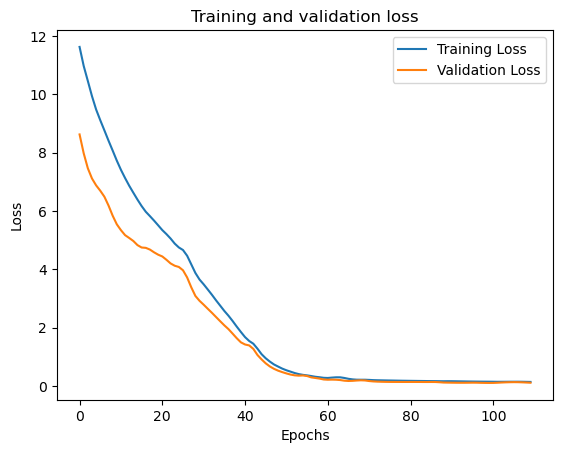

In [11]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

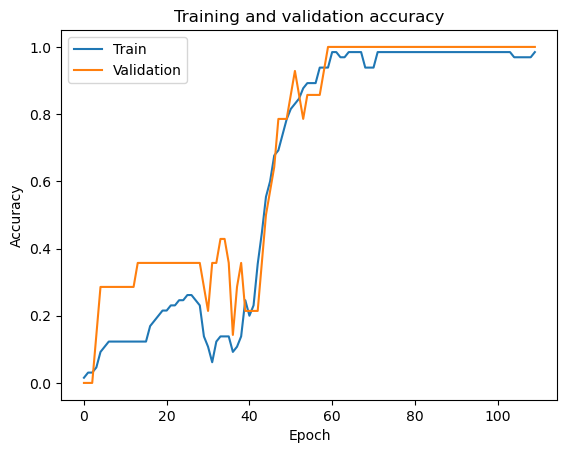

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validation accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

1/1 [==============================] - 0s 181ms/step - loss: 0.0867 - accuracy: 1.0000
Test accuracy: 1.0


In [14]:
# make predictions using validate dataset
predictions = model.predict(X_val)

1/1 [==============================] - 0s 118ms/step


In [15]:
# (using validate_dataset)
# step 1: Make predictions
predictions = model.predict(X_val)

#step 2: get the first ten predictions
first_ten_predictions = predictions[:10]

# step 3: print the first ten predictions and their classified results
print("First ten predictions:")
for i, prediction in enumerate(first_ten_predictions, start=1):
    predicted_class = label_encoder.inverse_transform([tf.argmax(prediction).numpy()])[0]
    print(f"Sample {i}: Classified as - {predicted_class} (Raw probabilities: {prediction})")

1/1 [==============================] - 0s 16ms/step
First ten predictions:
Sample 1: Classified as - Ceylon olive (Raw probabilities: [9.8415744e-01 3.3114589e-05 1.5809376e-02])
Sample 2: Classified as - Hibiscus (Raw probabilities: [5.4266938e-04 8.2138434e-02 9.1731894e-01])
Sample 3: Classified as - Governor's plum (Raw probabilities: [8.6419098e-04 9.4060791e-01 5.8527857e-02])
Sample 4: Classified as - Hibiscus (Raw probabilities: [1.1604943e-04 6.0515292e-02 9.3936867e-01])
Sample 5: Classified as - Hibiscus (Raw probabilities: [1.0318679e-04 1.6895486e-01 8.3094198e-01])
Sample 6: Classified as - Governor's plum (Raw probabilities: [0.03220593 0.6102801  0.3575139 ])
Sample 7: Classified as - Governor's plum (Raw probabilities: [0.00817405 0.87037766 0.12144832])
Sample 8: Classified as - Ceylon olive (Raw probabilities: [9.9766344e-01 1.7809781e-04 2.1584998e-03])
Sample 9: Classified as - Ceylon olive (Raw probabilities: [9.9906319e-01 3.3297404e-04 6.0384755e-04])
Sample 10:

In [16]:
# (using test_dataset)
# step 1: Make predictions
predictions = model.predict(X_test)

#step 2: get the first ten predictions
first_10_predictions = predictions[:10]

# step 3: print the first ten predictions and their classified results
print("First ten predictions:")
for i, prediction in enumerate(first_10_predictions, start=1):
    predicted_class = label_encoder.inverse_transform([tf.argmax(prediction).numpy()])[0]
    print(f"Sample {i}: Classified as - {predicted_class} (Raw probabilities: {prediction})")

1/1 [==============================] - 0s 16ms/step
First ten predictions:
Sample 1: Classified as - Ceylon olive (Raw probabilities: [9.9773079e-01 1.2867943e-04 2.1405807e-03])
Sample 2: Classified as - Hibiscus (Raw probabilities: [6.1086873e-03 3.1150972e-05 9.9386013e-01])
Sample 3: Classified as - Governor's plum (Raw probabilities: [0.00134071 0.62899894 0.36966035])
Sample 4: Classified as - Hibiscus (Raw probabilities: [9.7181342e-05 5.4099329e-02 9.4580346e-01])
Sample 5: Classified as - Hibiscus (Raw probabilities: [8.7400654e-04 1.2435846e-04 9.9900156e-01])
Sample 6: Classified as - Governor's plum (Raw probabilities: [0.00165296 0.93071485 0.06763221])
Sample 7: Classified as - Hibiscus (Raw probabilities: [5.8223470e-04 1.2699299e-03 9.9814785e-01])
Sample 8: Classified as - Ceylon olive (Raw probabilities: [9.9909127e-01 5.8503781e-04 3.2367068e-04])
Sample 9: Classified as - Ceylon olive (Raw probabilities: [9.9900502e-01 7.0270413e-04 2.9230068e-04])
Sample 10: Classi